In [297]:
# Todo: balance dataset? 

# is Embedding(max_words, 32, input_length=maxlen) correct?

# remove stopwords?
# lemmetize?

# add misc section to the explanation text?

# why embedding layer?

# Sentiment Analysis

In [310]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


### Load & explore data

In [314]:
data = pd.read_csv('emotions.csv')
data

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness
...,...,...
19995,i was i might be buying stuff from there but i...,joy
19996,i like sonam deepika and genelia who i feel ar...,joy
19997,i feel pathetic that i can hardly go a whole d...,sadness
19998,id have spent more time with her on reading i ...,sadness


In [322]:
# Find the longest row and count the number of chars/words. Useful in order to set an
# appropriate max_words for pad_sequences later on
longest_row_index = data['text'].str.len().idxmax()
longest_row = data['text'].loc[longest_row_index]

longest_row_char_count = len(longest_row)
longest_row_word_count = len(longest_row.split(' '))

print(
    f'longest row\n',
    f'characters: {longest_row_char_count}\n',
    f'words: {longest_row_word_count}'
)

longest row
 characters: 300
 words: 62


In [325]:
# Looks like we sadly don't have enough data to balance the dataset
print(data['label'].value_counts())

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


### Preprocessing

In [326]:
max_words_to_use = 1000

# Tokenize the text data (convet them into "sequences")
tokenizer = Tokenizer(num_words=max_words_to_use) # Consider only using the top 1000 words, as those 
tokenizer.fit_on_texts(data['text'])
tokenized_data = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing (i fucking hate python sometimes man. Someone ought to be burned at the stake for their sins)
for i in range(5):
    print(f'seq {i}: {tokenized_data[i]}')

seq 0: [1, 2, 14, 513, 161, 115, 76, 274, 277, 3, 68, 178]
seq 1: [73, 322, 12, 99, 131, 6, 275, 29, 5, 24, 10, 3, 5, 10, 714, 119, 14, 84, 3, 152, 495]
seq 2: [1, 116, 2, 12, 21, 762, 8, 35, 5, 964, 9, 87, 4, 782, 5, 367, 57, 27, 50]
seq 3: [1, 2, 665, 6, 203, 187]
seq 4: [1, 323, 4, 300, 8, 6, 7, 13, 763, 18, 4, 27, 614, 34, 111, 162, 37, 29, 22, 11, 6, 242]


In [303]:
max_sequence_length = 100

# Pad the sequences to make them of uniform length
tokenized_padded_data = pad_sequences(tokenized_data, maxlen=max_sequence_length)
print(tokenized_padded_data[:2])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2
   14 513 161 115  76 274 277   3  68 178]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0  73 322  12  99 131   6 275  29   5  24  10
    3   5  10 714 119  14  84   3 152 495]]


In [327]:
# One-hot encode the labels
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])
print(onehot_encoded_labels)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


In [328]:
x_train, x_test, y_train, y_test = train_test_split(
    tokenized_padded_data,
    onehot_encoded_labels,
    test_size=0.2,
    random_state=42
)

print(
    f'x_train shape: {np.shape(x_train)}\n'
    f'y_train shape: {np.shape(y_train)}\n'
    f'x_test shape: {np.shape(x_test)}\n'
    f'y_test shape: {np.shape(y_test)}'
)

x_train shape: (16000, 100)
y_train shape: (16000, 6)
x_test shape: (4000, 100)
y_test shape: (4000, 6)


### Create & train model

In [306]:
model = Sequential([
    Embedding(
        input_dim=max_words_to_use,
        input_length=max_sequence_length,
        output_dim=32
    ),
    SimpleRNN(units=32),
    Dense(32, activation='softmax'), # needed?
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [338]:
model = Sequential([
    Embedding(
        input_dim=max_words_to_use,
        input_length=max_sequence_length,
        output_dim=32
    ),
    LSTM(32),
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [339]:
# Using a patience and start_from_epoch of 10 as the model is still all over the place before that 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)

# Train the model
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


400/400 [==============================] - 25s 50ms/step - loss: 1.4217 - accuracy: 0.4420 - val_loss: 0.9973 - val_accuracy: 0.6344
Epoch 2/100
400/400 [==============================] - 22s 56ms/step - loss: 0.8666 - accuracy: 0.7045 - val_loss: 0.7856 - val_accuracy: 0.7241
Epoch 3/100
400/400 [==============================] - 20s 49ms/step - loss: 0.6249 - accuracy: 0.7920 - val_loss: 0.6094 - val_accuracy: 0.7925
Epoch 4/100
400/400 [==============================] - 19s 48ms/step - loss: 0.4243 - accuracy: 0.8549 - val_loss: 0.4390 - val_accuracy: 0.8491
Epoch 5/100
400/400 [==============================] - 19s 48ms/step - loss: 0.3261 - accuracy: 0.8874 - val_loss: 0.4148 - val_accuracy: 0.8628
Epoch 6/100
400/400 [==============================] - 20s 50ms/step - loss: 0.2865 - accuracy: 0.8973 - val_loss: 0.4013 - val_accuracy: 0.8703
Epoch 7/100
400/400 [==============================] - 19s 47ms/step - loss: 0.2582 - accuracy: 0.9043 - val_loss: 0.4103 - val_accuracy: 0.86

In [345]:
models = {
    'RNN':
    Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        SimpleRNN(units=32),
        Dense(32, activation='softmax'), # needed?
        Dense(6, activation='softmax')
    ]),
    
    'LSTM':
    Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        SimpleRNN(units=32),
        Dense(32, activation='softmax'), # needed?
        Dense(6, activation='softmax')
    ])
}

In [ ]:
for name, model in models.items():
    
    print(f'Training {name}')
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that 
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)

    # Train the model
    history = model.fit(x_train, y_train, epochs=2, validation_split=0.2, callbacks=[early_stopping])

### Evaluate performance

In [340]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

  7/125 [>.............................] - ETA: 2s - loss: 0.2556 - accuracy: 0.8929

125/125 [==============================] - 2s 19ms/step - loss: 0.3767 - accuracy: 0.8720


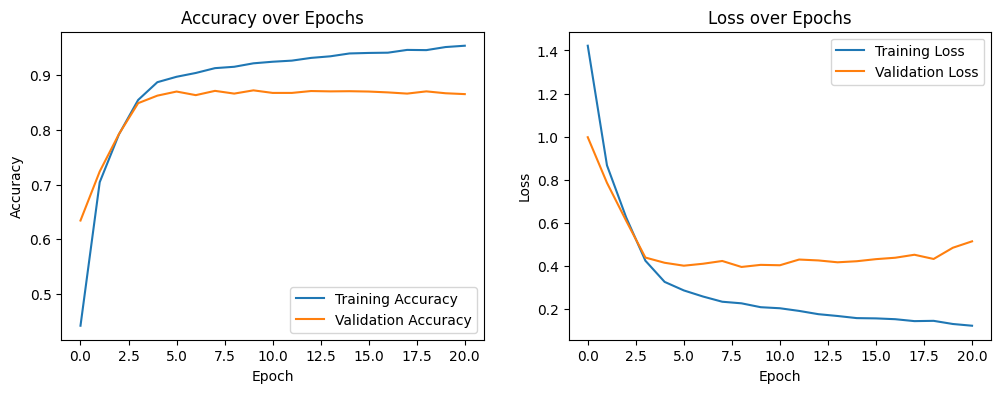

Accuracy: 87.0%
Loss: 0.38


In [341]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)